In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import logging

import matplotlib.pyplot as plt
import torch
from pykeen.datasets import Nations
from pykeen.pipeline import pipeline
from statistics import mean, median
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from ipywidgets import interact
import ipywidgets as widgets
from itertools import chain
from pathlib import Path
from rich import print

from utils import prepare_for_visualization

## Settings

In [4]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

pd.set_option("display.float_format", lambda x: "%.5f" % x)
logging.getLogger("pykeen").setLevel(logging.CRITICAL)

## Loading data

In [5]:
dataset = Nations()

g = nx.DiGraph()
g.add_edges_from([(h, t, {"title": r}) for h, r, t in dataset.training.triples])

## Visualization

In [6]:
nt = Network("500px", "500px", directed=True, notebook=True)
nt.inherit_edge_colors(False)
nt.from_nx(g)
nt.toggle_physics(False)
nt.show("basic.html")

basic.html


In [7]:
_list_nodes = list(g.nodes)


@interact
def visualize(
    nodes=widgets.SelectMultiple(options=list(g.nodes), value=[_list_nodes[0]]),
    k=[0, 1, 2, 3],
    toggle_physics=False,
):
    filtered = set(
        chain(
            *[
                list(nx.single_source_shortest_path_length(g, n, cutoff=k))
                for n in nodes
            ]
        )
    )
    # print(filtered)
    subgraph = nx.subgraph_view(g, filter_node=lambda x: x in filtered)
    nt = Network(
        "500px", "500px", directed=True, notebook=True, cdn_resources="in_line"
    )
    nt.inherit_edge_colors(False)
    nt.from_nx(subgraph)
    nt.toggle_physics(toggle_physics)
    display(nt.show("basic.html"))

interactive(children=(SelectMultiple(description='nodes', index=(0,), options=('brazil', 'china', 'cuba', 'pol…

## EDA

In [8]:
data = []
for subset_name in ["training", "validation", "testing"]:
    subset_metrics = {"subset": subset_name}
    subset = dataset.__getattribute__(subset_name)
    triples = subset.triples
    subset_metrics["num_triples"] = len(triples)
    subset_metrics["num_entities"] = len(np.unique(triples[:, [0, 2]]))
    subset_metrics["num_relations"] = len(np.unique(triples[:, 1]))
    data.append(subset_metrics)

pd.DataFrame(data)

,subset,num_triples,num_entities,num_relations
0,training,1592,14,55
1,validation,199,14,45
2,testing,201,14,41


In [9]:
metrics = {}
metrics["n_connected_components"] = nx.number_connected_components(g.to_undirected())
metrics["mean_size_of_connected_components"] = mean(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["median_size_of_connected_components"] = median(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["density"] = nx.density(g)
metrics["number_of_selfloops"] = nx.number_of_selfloops(g)
metrics["average_clustering"] = nx.average_clustering(g)

pd.DataFrame({"training": metrics})

,training
average_clustering,1.00000
density,1.00000
mean_size_of_connected_components,14.00000
median_size_of_connected_components,14.00000
n_connected_components,1.00000
number_of_selfloops,0.00000


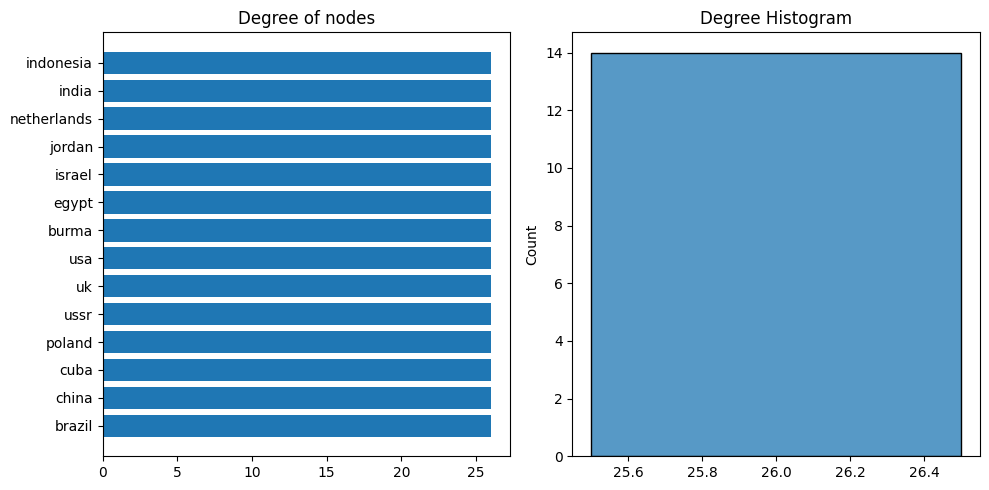

In [10]:
x, y = zip(*g.degree())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Degree of nodes")
axes[0].barh(y=x, width=y)
axes[1].set_title("Degree Histogram")
sns.histplot([d for n, d in g.degree()], ax=axes[1])
plt.tight_layout()

## Training 

In [11]:
result = pipeline(
    dataset="Nations",
    model="TransE",
    model_kwargs={"embedding_dim": 64},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=50,
        batch_size=512,
        use_tqdm_batch=False,
    ),
    random_seed=123,
)

Training epochs on cpu:   0%|          | 0/50 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/201 [00:00<?, ?triple/s]

In [12]:
save_location = Path("results/nations")
save_location.mkdir(exist_ok=True, parents=True)
result.save_to_directory(save_location)
print(f"Saved: {os.listdir(save_location)}")

Saved: ['trained_model.pkl', 'results.json', 'training_triples', 'metadata.json']

## Metrics

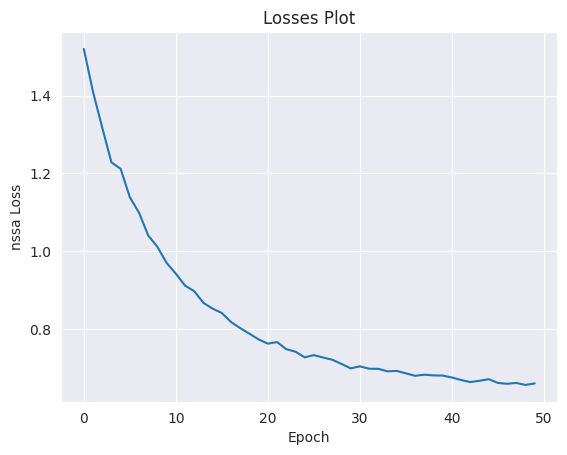

In [13]:
result.plot_losses()
plt.show()

In [14]:
metrics = result.metric_results.to_df()

In [15]:
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")]

,Side,Type,Metric,Value
5,both,realistic,count,402.00000
14,both,realistic,adjusted_geometric_mean_rank_index,0.12280
23,both,realistic,adjusted_inverse_harmonic_mean_rank,-0.05211
32,both,realistic,inverse_geometric_mean_rank,0.31589
41,both,realistic,median_absolute_deviation,1.48260
50,both,realistic,adjusted_arithmetic_mean_rank_index,0.23176
59,both,realistic,variance,5.60860
68,both,realistic,geometric_mean_rank,3.16570
77,both,realistic,adjusted_arithmetic_mean_rank,0.82000
86,both,realistic,standard_deviation,2.36825


## Embeddings visualization

In [16]:
model = result.model
model

TransE(
  (loss): NSSALoss()
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(14, 64)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(55, 64)
    )
  )
  (weight_regularizers): ModuleList()
)

In [17]:
embeddings = result.model.entity_representations[0](torch.arange(dataset.num_entities))
labels = [dataset.training.entity_id_to_label[i] for i in range(dataset.num_entities)]

In [18]:
prepare_for_visualization(embeddings.detach().numpy(), labels, Path("logs/nations"))

In [19]:
!tensorboard --logdir=logs/nations


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [24]:
result.model.relation_representations[0]

Embedding(
  (_embeddings): Embedding(55, 64)
)

In [67]:
result.model.eval()


@interact
def predict(
    head=list(sorted(dataset.training.entity_id_to_label.values())),
    relation=list(sorted(dataset.training.relation_id_to_label.values())),
):
    print(f"{head}, {relation}, ?")

    e_id = dataset.training.entity_to_id[head]
    rel_id = dataset.training.relation_to_id[relation]

    emb_ent = embeddings[e_id]
    emb_rel = result.model.relation_representations[0](torch.tensor([rel_id]))
    print((emb_ent + emb_rel - embeddings).shape)
    dist = ((emb_ent + emb_rel - embeddings) ** 2).sum(dim=-1)

    _, idx = torch.topk(dist, 10, largest=False)
    for i in idx:
        print(dataset.training.entity_id_to_label[i.item()])

interactive(children=(Dropdown(description='head', options=('brazil', 'burma', 'china', 'cuba', 'egypt', 'indi…

In [49]:
emb_ent + emb_rel

NameError: name 'emb_ent' is not defined